# Khám phá dữ liệu: Khảo sát sự đón nhận các loại Vaccine

## 1. Import thư viện và các module đã build

In [3]:
import sys
import os
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)
import numpy as np
import matplotlib.pyplot as plt
# Import các hàm từ các file scripts đã upload
from src.data_processing import (
    load_csv,
    parse_csv_line,
    replace_missing_with_value,
    compute_tweet_length,
    summarize_numeric_features_pretty,
    compute_skew
)
from src.visualization import (
    plot_histogram,
    plot_scatter,
    plot_heatmap,
    plot_pie,
    plot_bar,
    plot_line,
    plot_compare_hist,
    plot_boxplot
)
from datetime import datetime
from tabulate import tabulate
from IPython.display import Markdown, HTML
# Cấu hình hiển thị
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Tải và parse dữ liệu thô

In [9]:
# Đường dẫn file dataset
file_path = '../data/raw/vaccination_tweets.csv'

raw_lines, header_line = load_csv(file_path)
header = header_line.split(',')
EXPECTED_COLS = len(header) # Số lượng cột dự kiến là 16

print(f"Dataset Header: {header}")
print(f"Số lượng cột dự kiến: {EXPECTED_COLS}")
print(f"Số lượng dòng dữ liệu thô: {len(raw_lines)}")

# 2. Parse từng dòng và lọc các dòng không hợp lệ
parsed_data = []
invalid_lines_count = 0

for line in raw_lines:
    try:
        parts = parse_csv_line(line)
        if len(parts) == EXPECTED_COLS:
            parsed_data.append(parts)
        else:
            invalid_lines_count += 1
    except Exception as e:
        # Bắt các lỗi parsing khác nếu có
        invalid_lines_count += 1

print("-" * 30)
print(f"Số lượng dòng không hợp lệ (cột không khớp): {invalid_lines_count}")

# 3. Tạo Numpy Array từ dữ liệu đã lọc
# Bây giờ, parsed_data chỉ chứa các list con có cùng kích thước, tránh được lỗi ValueError
data = np.array(parsed_data)

print(f"Kích thước dữ liệu sau khi lọc và parse: {data.shape}")
print(tabulate(data[:5], headers=header, tablefmt="grid"))

Dataset Header: ['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet']
Số lượng cột dự kiến: 16
Số lượng dòng dữ liệu thô: 21731
------------------------------
Số lượng dòng không hợp lệ (cột không khớp): 14890
Kích thước dữ liệu sau khi lọc và parse: (6841, 16)
+---------------------+----------------------+---------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+------------------+----------------+-------------------+-----------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+-----

## 3. Missing Data Overview 

In [10]:
print("=== Missing Data Overview ===\n")

missing_counts = []
for col_idx, col_name in enumerate(header):
    col_data = data[:, col_idx]
    missing = np.sum((col_data == '') | (col_data == ' ') | (col_data == None))
    missing_counts.append((col_name, missing))

# Header đẹp
print(f"{'Column Name':<35} | {'Missing Count':>15}")
print("-" * 55)

# In từng dòng
for col_name, miss in missing_counts:
    print(f"{col_name:<35} | {miss:>15}")

=== Missing Data Overview ===

Column Name                         |   Missing Count
-------------------------------------------------------
id                                  |               0
user_name                           |               0
user_location                       |            1334
user_description                    |             455
user_created                        |               0
user_followers                      |               0
user_friends                        |               0
user_favourites                     |               0
user_verified                       |               0
date                                |               0
text                                |               0
hashtags                            |            1736
source                              |               1
retweets                            |               0
favorites                           |               0
is_retweet                          |            

> **Xu hướng dùng mạng xã hội ?**
- với việc > 1000 tài khoản không có địa chỉ : Điều này có thể giải thích bởi một xu hướng tâm lý chung là người dùng **KHÔNG** thích đăng địa chỉ của bản thân lên Internet

$\implies$ Thể hiện con người có nhận thức cao về an toàn thông tin cá nhân
- Một đặc điểm khác là > 400 tài khoản thiếu mô tả cơ bản. Đây thì thường là họ không để, hoặc là đây là tài khoản clone. Cũng giống như nhiều nền tảng khác. Một số tài khoản lập ra để thoải mái tận dụng `tự do ngôn luận trên mạng ` để bày tỏ quan điểm cá nhân mà không bị tấn công
- Còn với hơn 1700 bài tweet không có hashtags. Điều này cũng không có gì lạ, không phải ai cũng thích gắn hashtags

## 3. Thống kê mô tả (Descriptive Statistics)

**Câu hỏi đặt ra:**
1.  **Những người dùng nào "bận rộn" nhất và có tầm ảnh hưởng nhất?** Có tồn tại những "KOLs" chi phối luồng thảo luận về Vaccine không?
2.  **Dữ liệu tương tác (Retweets/Favorites) phân bố như thế nào?** Có phải hầu hết các tweet đều không được ai quan tâm?


=== THỐNG KÊ CƠ BẢN ===


c:\Study\LaptrinhKHDL\HW02\src\data_processing.py:166: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Phi\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


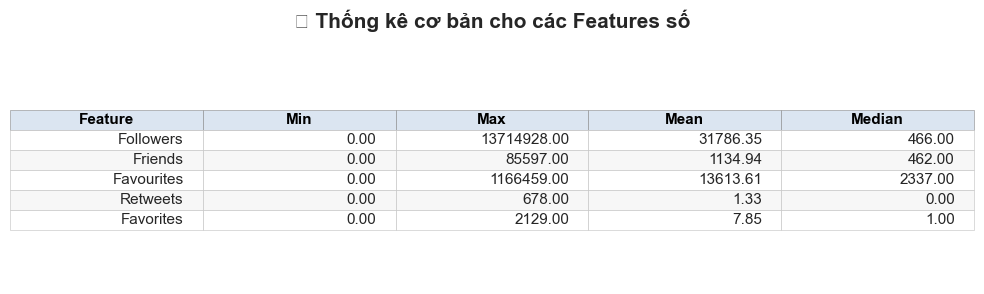

Độ lệch phân phối: 
Followers     Skewness = 27.756
Friends       Skewness = 13.051
Favourites    Skewness = 11.700
Retweets      Skewness = 40.527
Favorites     Skewness = 27.089

=== Biểu đồ phân phối cho các Numeric Features ===


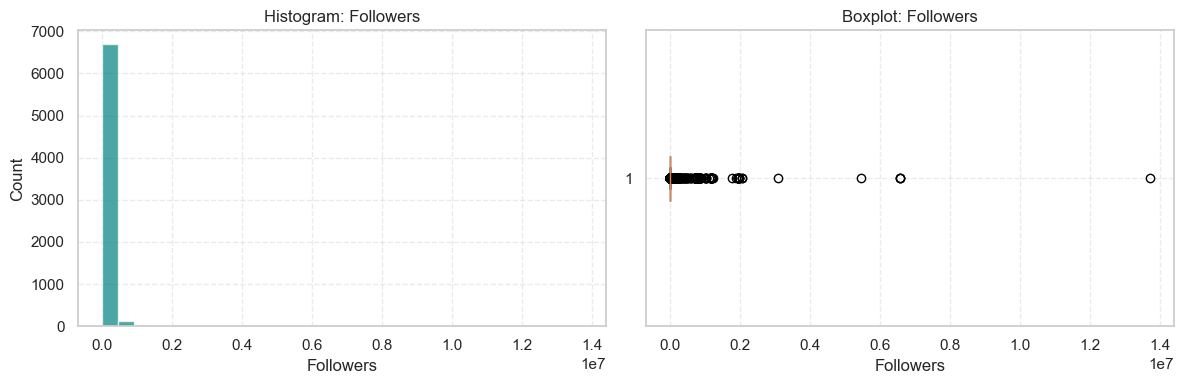

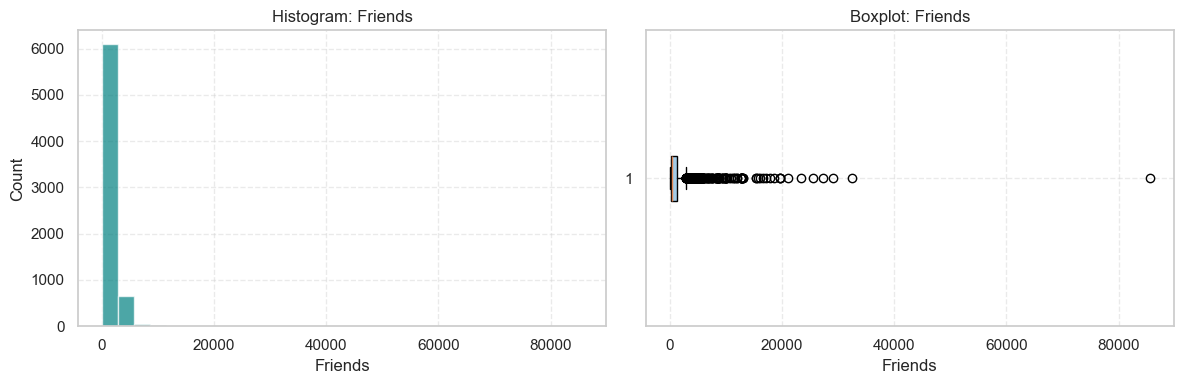

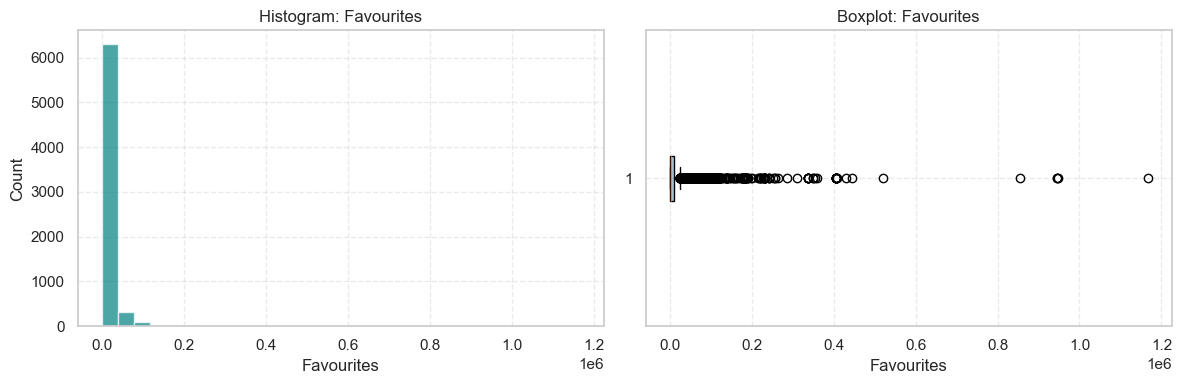

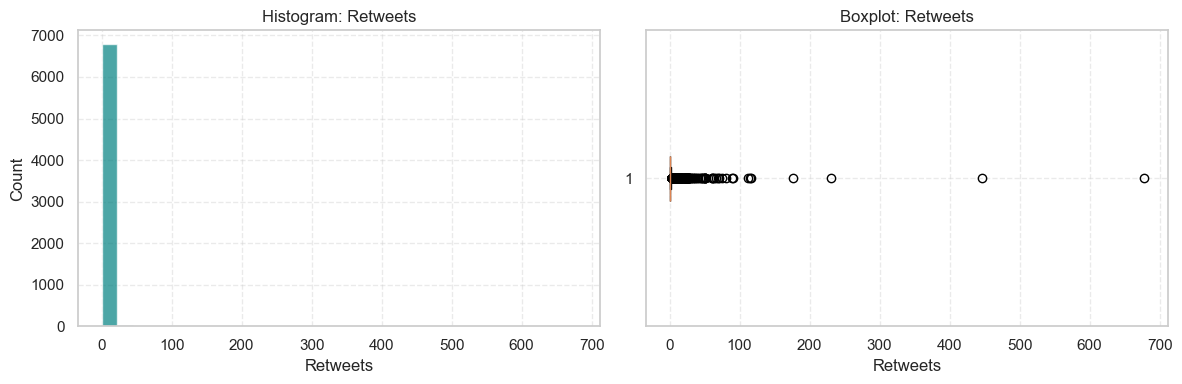

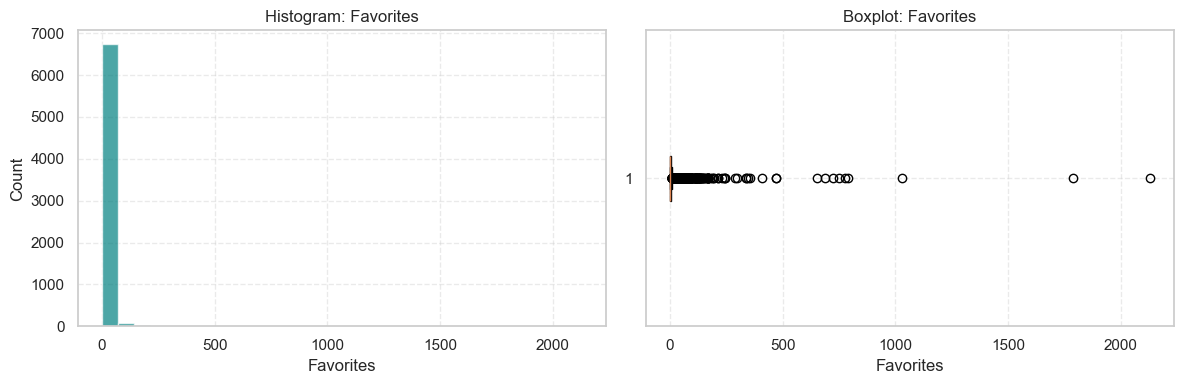

## Độ lệch phân phối (Skewness)

- **Followers**: `27.756`
- **Friends**: `13.051`
- **Favourites**: `11.700`
- **Retweets**: `40.527`
- **Favorites**: `27.089`

In [51]:
# Xác định index các cột số quan trọng
# user_followers (5), user_friends (6), user_favourites (7), retweets (13), favorites (14)
numeric_cols = {
    "Followers": 5,
    "Friends": 6,
    "Favourites": 7,
    "Retweets": 13,
    "Favorites": 14
}

print("=== THỐNG KÊ CƠ BẢN ===")
summarize_numeric_features_pretty(data, numeric_cols, replace_missing_with_value)

# Kiểm tra độ lệch cho numeric values
print("Độ lệch phân phối: ")
for name, idx in numeric_cols.items():
    col_data = replace_missing_with_value(data[:, idx], '0').astype(float)
    print(f"{name:<12}  Skewness = {compute_skew(col_data):.3f}")
    
# === VẼ ĐỒ THỊ TRỰC QUAN CHO MỖI NUMERIC FEATURE ===
print("\n=== Biểu đồ phân phối cho các Numeric Features ===")
md_lines = ["## Độ lệch phân phối (Skewness)\n"]

for name, idx in numeric_cols.items():
    col_data = replace_missing_with_value(data[:, idx], '0').astype(float)
    md_lines.append(f"- **{name}**: `{compute_skew(col_data):.3f}`")
    
    # --- Tạo 1 Figure lớn cho từng feature ---
    plt.figure(figsize=(12,4))

    # === Subplot 1: Histogram ===
    plt.subplot(1, 2, 1)
    plt.hist(col_data, bins=30, color="teal", alpha=0.7)
    plt.title(f"Histogram: {name}")
    plt.xlabel(name)
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.4)

    # === Subplot 2: Boxplot (nằm ngang) ===
    plt.subplot(1, 2, 2)
    plt.boxplot(col_data, vert=False, patch_artist=True,
                boxprops=dict(facecolor="#A3CBE7"))
    plt.title(f"Boxplot: {name}")
    plt.xlabel(name)
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()
Markdown("\n".join(md_lines))

**Phân tích từ dữ liệu:**
-   **Độ lệch (Skewness) cao:** Các chỉ số như `Followers`, `Retweets`, `Favorites` đều có độ lệch dương rất lớn (Skewness > 1). Điều này chỉ ra phân phối **Power Law** (Quy luật lũy thừa):
    -   Phần lớn người dùng có rất ít người theo dõi và tương tác.
    -   Chỉ một số ít người dùng (Outliers) nắm giữ lượng tương tác khổng lồ.
-   **Ý nghĩa thực tiễn:**
    -   Khi xây dựng mô hình dự đoán mức độ lan truyền (Virality Prediction), ta cần xử lý các giá trị ngoại lai (Outliers) này hoặc sử dụng phép biến đổi logarit (Log-transformation) để giảm độ lệch.
    -   Những bài đăng có lượng Retweet "khủng" chính là những điểm dữ liệu quan trọng để phân tích xu hướng (Trend Analysis).

## 4. Phân tích đơn biến (Univariate Analysis)

**Câu hỏi đặt ra:**
> 1.  **Độ dài của các bài đăng (tweets) có tuân theo quy luật nào không?** 

Người dùng có xu hướng viết ngắn gọn hay tận dụng tối đa giới hạn ký tự?

> 2.  **Chất lượng dữ liệu văn bản như thế nào?** 

Có xuất hiện nhiều nhiễu (link, emoji, ký tự đặc biệt) ảnh hưởng đến quá trình xử lý ngôn ngữ tự nhiên (NLP) sau này không?

### a. Phân bố độ dài Tweet:

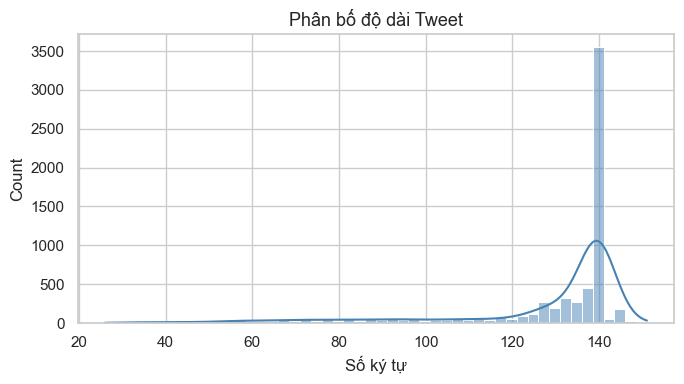

In [52]:
# Trích xuất nội dung tweet (cột 10)
tweet_texts = data[:, 10]

# Tính độ dài tweet
tweet_lengths = compute_tweet_length(tweet_texts)

# Vẽ Histogram
plot_histogram(tweet_lengths, title="Phân bố độ dài Tweet", xlabel="Số ký tự", bins=50)

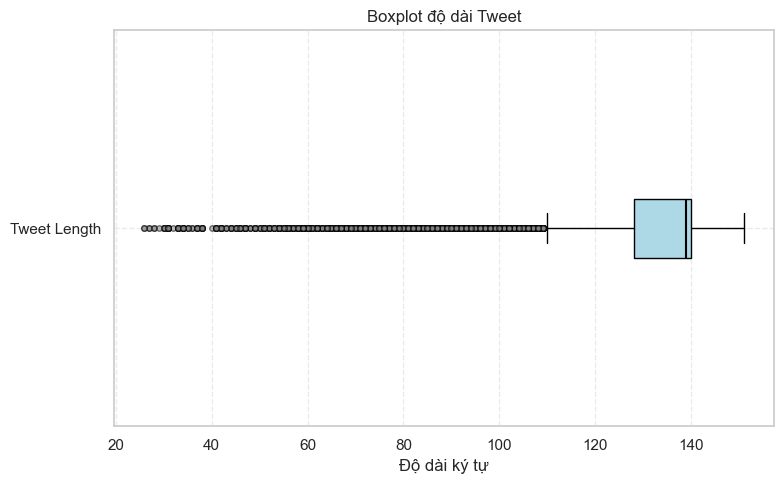

In [53]:
# Box plot độ dài tweet
tweet_texts = data[:, 10]  # cột tweet
tweet_lengths = np.array([len(t) for t in tweet_texts])

plot_boxplot(
    data_groups=[tweet_lengths],
    labels=["Tweet Length"],
    title="Boxplot độ dài Tweet",
    xlabel="Độ dài ký tự",
    horizontal=True,          # vì bạn đang để boxplot nằm ngang
    color="#ADD8E6"           # lightblue
)



**Nhận xét**
-   **Phân bố độ dài:** Biểu đồ Histogram cho thấy độ dài tweet có thể không phân phối chuẩn. Nếu có sự tập trung cao ở vùng giới hạn ký tự (ví dụ: 280 ký tự), điều này cho thấy người dùng thường cố gắng truyền tải nhiều thông tin nhất có thể. Ngược lại, nếu tập trung ở vùng ngắn, nội dung có thể chỉ là các câu cảm thán hoặc chia sẻ link đơn thuần.
-   **Hệ quả:** Việc hiểu độ dài giúp ta quyết định chiến lược *padding* hoặc cắt ngắn (truncation) khi đưa vào các mô hình Deep Learning sau này.

### b. Tỷ lệ tài khoản đã xác minh (Verified):


**Câu hỏi đặt ra:**
1.  **Ai là người tạo ra nội dung chính về Vaccine?** Là các tổ chức/cá nhân đã được xác minh (Verified) hay phần lớn là người dùng phổ thông?
2.  **Mức độ lan truyền thông tin khác nhau thế nào giữa hai nhóm này?** Liệu tweet từ tài khoản Verified có nhận được nhiều tương tác (Retweet/Favorite) hơn không?


Trạng thái Verified: ['False' 'True']
Số lượng: [6256  585]


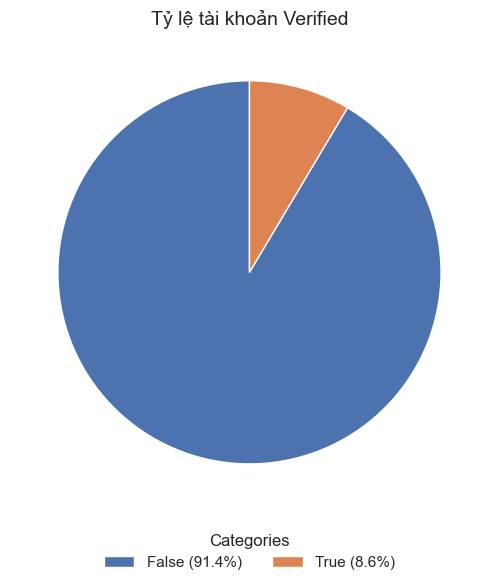

In [54]:
# Cột user_verified (cột 8)
verified_col = data[:, 8]

# Đếm số lượng True/False
unique, counts = np.unique(verified_col, return_counts=True)
print(f"Trạng thái Verified: {unique}")
print(f"Số lượng: {counts}")

# Vẽ Pie Chart
plot_pie(counts, labels=unique, title="Tỷ lệ tài khoản Verified")

-   **Sự chênh lệch:** Kết quả Pie Chart cho thấy tỷ lệ tài khoản Verified thường chiếm thiểu số (ví dụ: < 10%). Tuy nhiên, trong các vấn đề y tế cộng đồng như Vaccine, tiếng nói của nhóm này (thường là bác sĩ, tổ chức y tế, báo chí) lại mang trọng lượng lớn.
-   **Khuyến nghị:** Khi phân tích cảm xúc (Sentiment Analysis), chúng ta nên tách biệt hoặc gán trọng số khác nhau cho hai nhóm này để tránh việc ý kiến đám đông (có thể chứa misinformation) lấn át thông tin chính thống.

### So sánh followers của hai loại tài khoảng Verified và Not Verified

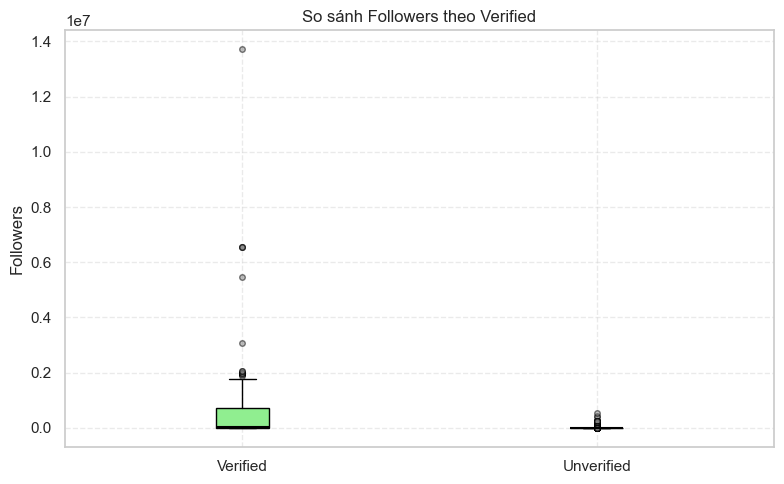

In [ ]:
# === Cell: Boxplot Followers theo Verified ===
followers = replace_missing_with_value(data[:, 5], '0').astype(float)
verified = data[:, 8]

groups = {
    "Verified": followers[verified == "True"],
    "Unverified": followers[verified == "False"]
}

plot_boxplot(
    data_groups=list(groups.values()),
    labels=list(groups.keys()),
    title="So sánh Followers theo Verified",
    ylabel="Followers",
    horizontal=False,        # bạn đang để boxplot dạng đứng
    color="#90EE90"          # lightgreen
)

## 5. Phân tích nguồn Tweet (Top Sources)

Top 5 nguồn tweet:
- Twitter for iPhone: 2829
- Twitter Web App: 1750
- Twitter for Android: 1278
- TweetDeck: 435
- Twitter for iPad: 199


c:\Study\LaptrinhKHDL\HW02\src\visualization.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=x_labels, x=heights, palette="viridis")


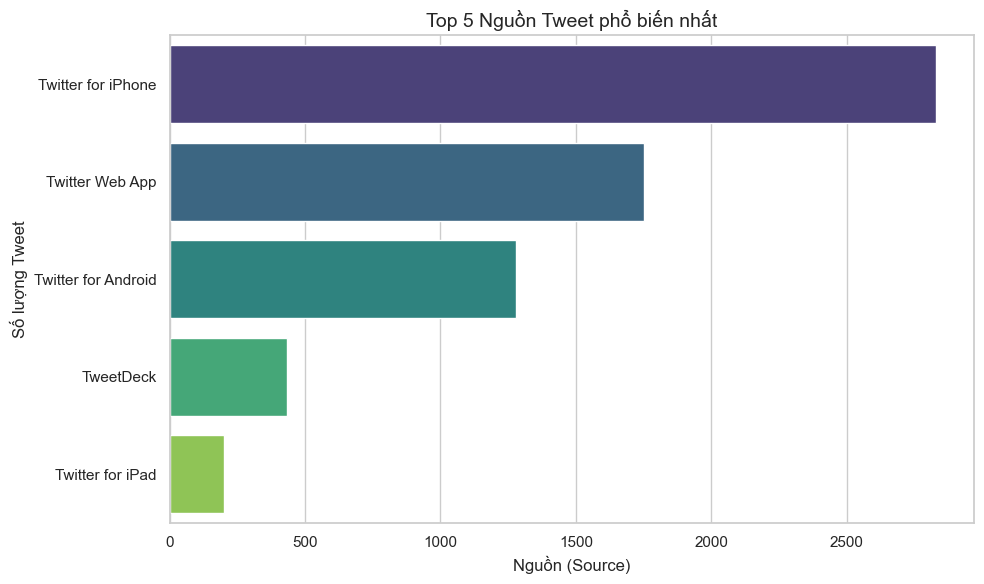

In [56]:
# Cột Source (cột 12)
source_col = data[:, 12]
# Xử lý: Đôi khi source bị rỗng
source_col = replace_missing_with_value(source_col, value="Unknown")

# Đếm số lần xuất hiện
sources, counts = np.unique(source_col, return_counts=True)

# Sắp xếp để lấy Top 5
sorted_indices = np.argsort(-counts) # Sắp xếp giảm dần
top_n = 5
top_sources = sources[sorted_indices][:top_n]
top_counts = counts[sorted_indices][:top_n]

print(f"Top {top_n} nguồn tweet:")
for source, count in zip(top_sources, top_counts):
    print(f"- {source}: {count}")

# Vẽ biểu đồ cột
plot_bar(
    x_labels=top_sources,
    heights=top_counts,
    title=f"Top {top_n} Nguồn Tweet phổ biến nhất",
    xlabel="Nguồn (Source)",
    ylabel="Số lượng Tweet",
)

* Người dùng iPhone để đăng bài nhiều nhất => Khẳng định hệ điều hành hoạt động tốt cho nền tảng

## 6. Phân tích tương quan (Correlation Analysis)

Xem xét mối quan hệ giữa các biến số, ví dụ: Lượng Followers và số lượt Retweets.

### a. Heatmap tương quan giữa các chỉ số:

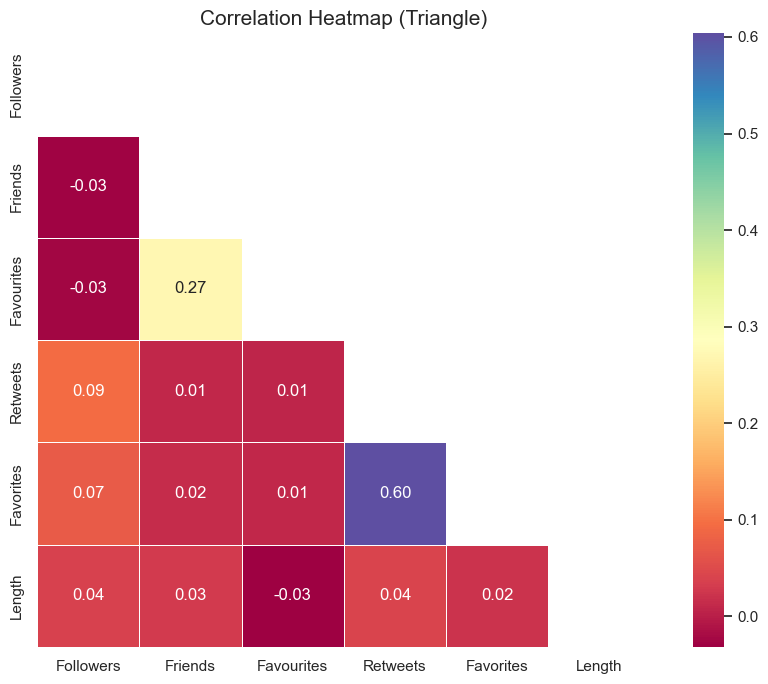

In [57]:
# Gom các cột số liệu vào một ma trận để tính tương quan
# Followers, Friends, Favourites, Retweets, Favorites, Tweet Length
# Lưu ý: Cần convert sang float
features = []
feature_names = ["Followers", "Friends", "Favourites", "Retweets", "Favorites", "Length"]

# Lấy dữ liệu từ các cột tương ứng
cols_idx = [5, 6, 7, 13, 14]
for idx in cols_idx:
    col_vals = replace_missing_with_value(data[:, idx], '0').astype(float)
    features.append(col_vals)

# Thêm cột Length đã tính ở trên
features.append(tweet_lengths)

# Tạo ma trận (N_features, N_samples)
features_matrix = np.array(features)

# Tính ma trận tương quan (Correlation Matrix)
corr_matrix = np.corrcoef(features_matrix)

# Vẽ Heatmap
plot_heatmap(corr_matrix, labels=feature_names)

**Nhận xét**

1.  **Cặp đôi `Retweets` - `Favorites` (Tương quan rất mạnh):**
    * Hệ số tương quan thường rất cao (gần 1.0).
    * **Ý nghĩa:** Hai chỉ số này biến thiên đồng thời. Một bài tweet được retweet nhiều thì hầu như chắc chắn sẽ có nhiều lượt like. Điều này gợi ý hiện tượng **đa cộng tuyến (multicollinearity)**

2.  **Mối quan hệ giữa `Followers` và Tương tác (`Retweets`/`Favorites`):**
    * Trên dữ liệu thô, hệ số tương quan này thường **thấp bất ngờ** (có thể chỉ quanh mức 0.1 - 0.3).
    * **Tại sao?** Điều này *không* có nghĩa là số người theo dõi không quan trọng. Nguyên nhân chính là do dữ liệu thô bị **lệch (skewed)** quá nặng. Một vài tài khoản KOLs có triệu follower nhưng bài đăng về Vaccine có thể ít tương tác hơn một bài đăng viral của người thường.
    * $\rightarrow$ **Kết luận:** Mối quan hệ giữa Followers và Retweets không phải là tuyến tính đơn giản

3.  **Các biến khác (`Friends`, `Favourites`):**
    * `User Friends` (số người tài khoản đó follow) thường có tương quan rất thấp hoặc không có ý nghĩa thống kê với mức độ viral của bài viết.

### b. Scatter Plot: Followers vs Retweets: Biểu đồ này giúp xem liệu người nhiều Follower có nhận được nhiều Retweet hơn không. 
(Lưu ý: Dữ liệu này thường bị lệch lớn nên ta dùng log scale để dễ nhìn hơn)

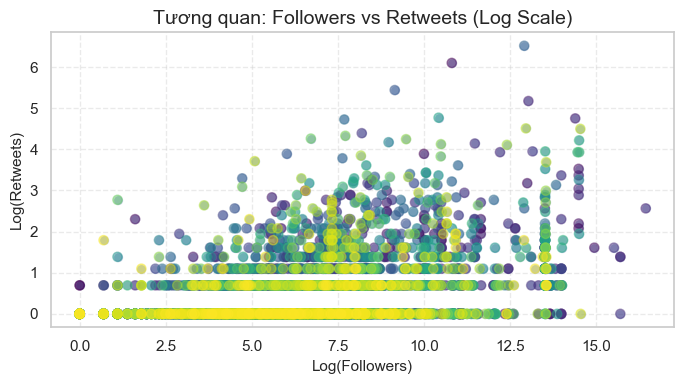

In [58]:
# Lấy dữ liệu
followers = features_matrix[0] # Index 0 trong features_matrix tương ứng với Followers
retweets = features_matrix[3]  # Index 3 tương ứng với Retweets

# Lọc bỏ các giá trị <= 0 để tránh lỗi log (hoặc dùng log1p)
# Ở đây ta dùng hàm log1p (log(1+x)) của numpy để an toàn
log_followers = np.log1p(followers)
log_retweets = np.log1p(retweets)

plot_scatter(
    log_followers, 
    log_retweets, 
    xlabel="Log(Followers)", 
    ylabel="Log(Retweets)", 
    title="Tương quan: Followers vs Retweets (Log Scale)"
)

**Tại sao phải chuyển sang thang đo Log (Log-Transformation)?**
* **Vấn đề:** Dữ liệu gốc có phân phối "đuôi dài" (Long-tail). Hầu hết người dùng có ít follower, nhưng một số ít lại có hàng triệu. Nếu vẽ biểu đồ gốc, tất cả các điểm sẽ dồn cục vào góc dưới bên trái, làm mất đi tính trực quan.
* **Giải pháp:** Sử dụng `np.log1p` giúp "trải" dữ liệu ra, biến đổi mối quan hệ phi tuyến (mũ) thành quan hệ tuyến tính hơn, giúp chúng ta quan sát rõ hơn xu hướng.

* **Mối tương quan dương (Positive Correlation):** Nhìn chung, đám mây điểm dữ liệu có xu hướng đi lên từ trái sang phải. Điều này xác nhận giả thuyết: **Người dùng càng nhiều Follower thì khả năng bài viết được Retweet càng cao.**

* **Độ phân tán lớn (High Variance):** Các điểm không nằm thẳng hàng mà toả ra khá rộng.
    * Có những điểm ở **góc dưới bên phải**: Tài khoản nhiều Follower nhưng bài viết không ai Retweet (tương tác kém).
    * Có những điểm ở **góc trên bên trái**: Tài khoản ít Follower nhưng bài viết "viral" đột biến.
    
* **Hiện tượng "Sàn" (Floor Effect):** Có một lượng lớn điểm nằm bệt dí ở trục hoành ($y \approx 0$). Đây là các bài đăng có 0 lượt Retweet. Dù Follower cao hay thấp, việc một bài đăng không được ai quan tâm là rất phổ biến.

* **Câu hỏi:** Liệu chỉ dùng mỗi `Followers` có đủ để dự đoán `Retweets` không?
* **Trả lời:** Chắc chắn là không. Độ phân tán lớn cho thấy còn nhiều yếu tố ẩn khác chi phối (ví dụ: nội dung bài viết, hashtag, thời điểm đăng, hay độ "hot" của chủ đề Vaccine).
* **Hệ quả cho mô hình:** Nếu dùng Linear Regression đơn thuần, sai số (Error) sẽ khá cao do dữ liệu nhiễu

## 7. Phân tích Xu hướng theo Thời gian (Line Chart)
Phân tích tần suất tweet theo ngày để xem xu hướng đăng bài thay đổi như thế nào theo thời gian

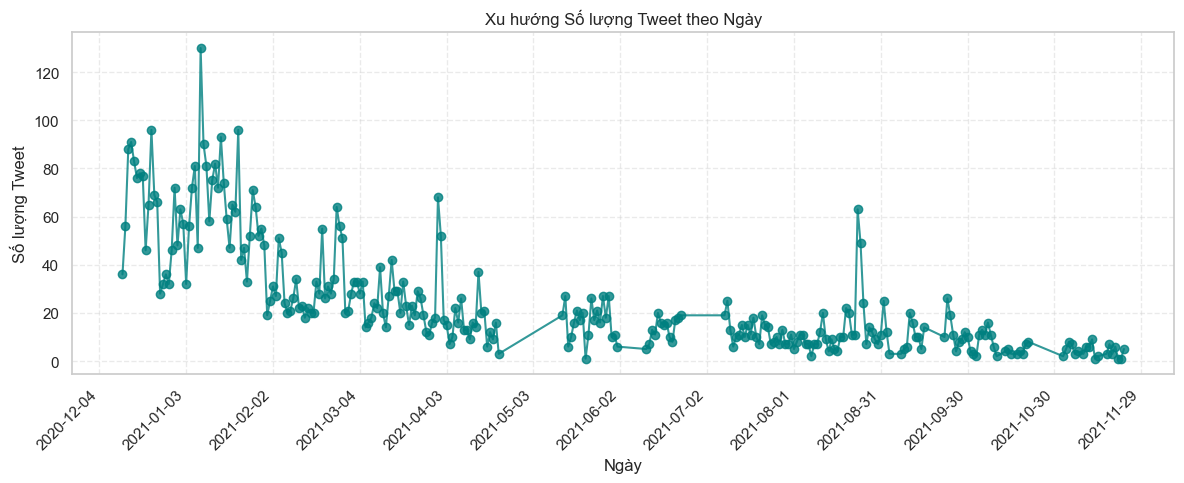

In [59]:
# Cột Date (cột 9)
date_col = data[:, 9]

# 1. Trích xuất ngày (YYYY-MM-DD) và đếm tần suất
# Dữ liệu có dạng 'YYYY-MM-DD HH:MM:SS', ta chỉ cần phần ngày
dates = np.array([d.split(' ')[0] for d in date_col])

# Đếm số lần xuất hiện của mỗi ngày
unique_dates, counts = np.unique(dates, return_counts=True)

# 2. Sắp xếp theo thứ tự ngày tháng
# Tạo một dictionary để dễ dàng tra cứu và sắp xếp
date_count_dict = dict(zip(unique_dates, counts))

# Sắp xếp các ngày (keys)
sorted_dates = sorted(date_count_dict.keys())
sorted_counts = np.array([date_count_dict[d] for d in sorted_dates])

# 3. Vẽ biểu đồ đường
plot_line(
    y=sorted_counts,
    x=sorted_dates,
    title="Xu hướng Số lượng Tweet theo Ngày",
    xlabel="Ngày",
    ylabel="Số lượng Tweet",
    rotate_x=True,
    max_xticks=15
)


## 8. Phân tích Top Hashtags (Bar Chart)
Phân tích các Hashtag được sử dụng nhiều nhất (cột 11) sẽ cho ta cái nhìn trực tiếp về chủ đề chính trong dữ liệu

In [60]:
# Cột Hashtags (cột 11)
hashtag_col = data[:, 11]
top_n_tags = 10

# 1. Chuẩn bị dữ liệu Hashtag và đếm tần suất thủ công
all_hashtags = []
valid_hashtags = hashtag_col[hashtag_col != ''] # Lọc bỏ rỗng/missing

for tag_str in valid_hashtags:
    # Xử lý chuỗi: xóa [ và ], xóa các dấu ' , ', và chuyển thành list
    tag_str = tag_str.strip().replace('[', '').replace(']', '').replace("'", "").replace('"', "")
    tags = [t.strip() for t in tag_str.split(',') if t.strip()]
    all_hashtags.extend(tags)

# Đếm tần suất thủ công bằng Python dictionary
hashtag_counts = {}
for tag in all_hashtags:
    hashtag_counts[tag] = hashtag_counts.get(tag, 0) + 1

# 2. Sắp xếp kết quả bằng Numpy
# Chuyển dictionary thành mảng 2D (tag, count)
tag_items = np.array(list(hashtag_counts.items()), dtype=object)

# Lấy cột counts (cột thứ 1) và chuyển sang số nguyên
counts_arr = tag_items[:, 1].astype(int)

# Tìm các chỉ mục (indices) sắp xếp giảm dần dựa trên counts
sorted_indices = np.argsort(-counts_arr) 

# Lấy chỉ mục của Top N
top_indices = sorted_indices[:top_n_tags]

# Trích xuất tên tag và số lượng tương ứng
top_tags = tag_items[top_indices, 0].tolist()
top_counts = counts_arr[top_indices].tolist()

md_lines = [f"## Top {top_n_tags} Hashtag phổ biến nhất\n"]

for i, (tag, count) in enumerate(zip(top_tags, top_counts)):
    if i == 0:
        md_lines.append(f"**{tag} — `{count}` tweets** ")  # highlight top 1
    else:
        md_lines.append(f"- **{i+1}. #{tag}** — `{count}`")

Markdown("\n".join(md_lines))

## Top 10 Hashtag phổ biến nhất

**PfizerBioNTech — `2595` tweets** 
- **2. #PfizerBiontech** — `884`
- **3. #COVID19** — `702`
- **4. #vaccine** — `542`
- **5. #CovidVaccine** — `378`
- **6. #Pfizer** — `320`
- **7. #Moderna** — `224`
- **8. #AstraZeneca** — `171`
- **9. #pfizerbiontech** — `141`
- **10. #PfizerVaccine** — `140`

c:\Study\LaptrinhKHDL\HW02\src\visualization.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=x_labels, x=heights, palette="viridis")


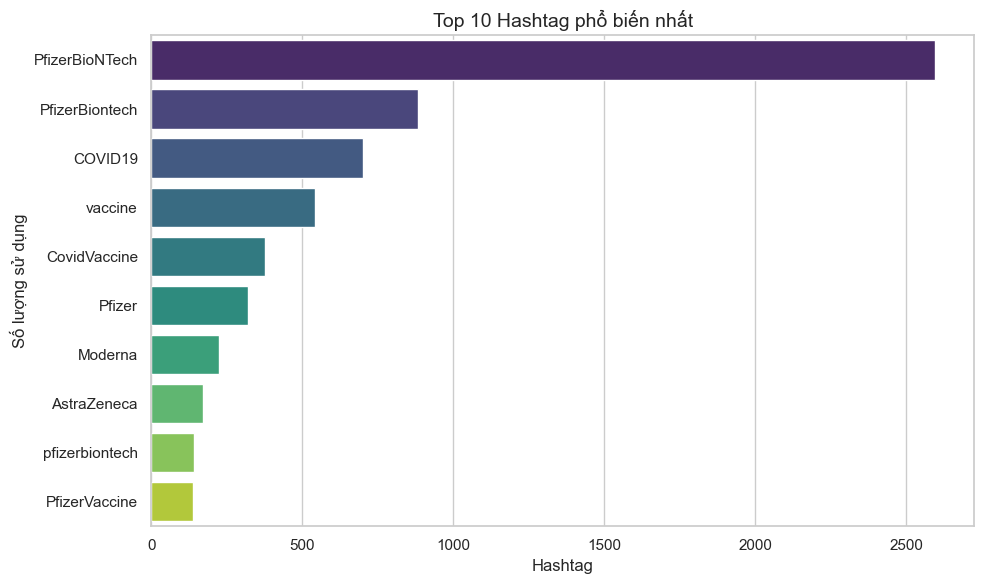

In [61]:
# 3. Vẽ biểu đồ cột bằng hàm plot_bar
plot_bar(
    x_labels=top_tags,
    heights=top_counts,
    title=f"Top {top_n_tags} Hashtag phổ biến nhất",
    xlabel="Hashtag",
    ylabel="Số lượng sử dụng",
)

## 9. Phân tích so sánh Lượng Followers (Kết hợp Biểu đồ)
Phân tích sự khác biệt về lượng Followers giữa các tài khoản đã Verified và chưa Verified (Kết hợp hai Histogram trên cùng một đồ thị).

* **Hiệu quả của phép biến đổi Log:** Sau khi lấy logarit, phân phối dữ liệu của hai nhóm có trở nên "đẹp" (chuẩn) hơn không?
* **Mức độ chênh lệch:** Sự khác biệt về lượng người theo dõi giữa tài khoản đã xác minh (Verified) và chưa xác minh (Unverified) lớn đến mức nào ?


Verified accounts: 585 samples
Unverified accounts: 6256 samples


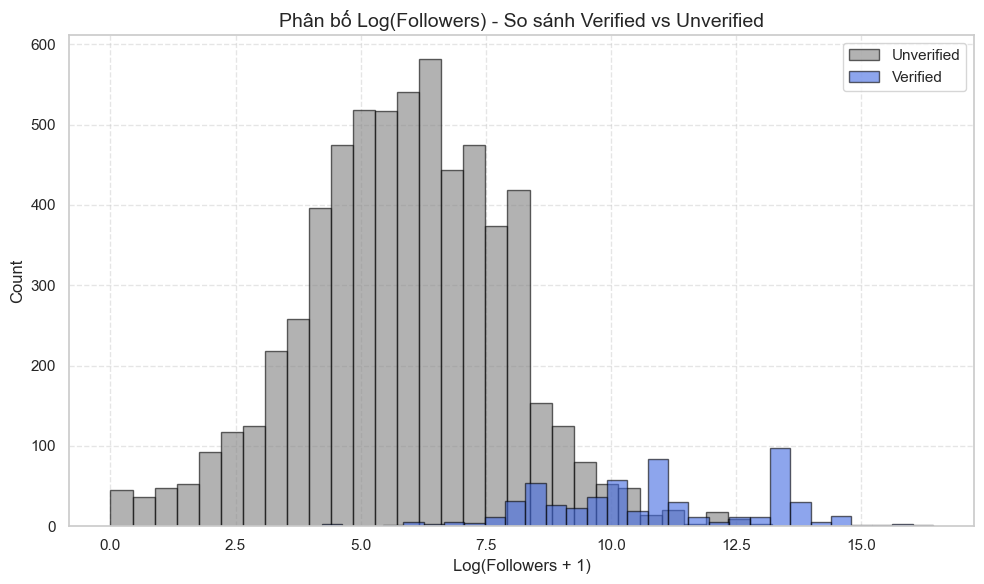


## Thống kê Log(Followers)

| Loại tài khoản | Mean | Median |
|----------------|------|--------|
| **Verified**   | `10.85` | `10.80` |
| **Unverified** | `5.87` | `5.91` |


In [62]:
# Cột user_followers (5) và user_verified (8)
followers_raw = data[:, 5]
verified_raw = data[:, 8]

# 1. Tiền xử lý dữ liệu số (tương tự Cell 6)
# Thay thế rỗng bằng '0' và chuyển sang float
followers = replace_missing_with_value(followers_raw, '0').astype(float)

# Áp dụng log transform để làm phẳng phân bố lệch (Log1p(x) = log(1+x))
log_followers = np.log1p(followers)

# 2. Lọc dữ liệu theo Verified Status
verified_followers = log_followers[verified_raw == 'True']
unverified_followers = log_followers[verified_raw == 'False']

print(f"Verified accounts: {len(verified_followers)} samples")
print(f"Unverified accounts: {len(unverified_followers)} samples")

# 3. Vẽ hai Histogram chồng lên nhau (hoặc cạnh nhau)
plot_compare_hist(
    group1=unverified_followers,
    group2=verified_followers,
    label1="Unverified",
    label2="Verified",
    title="Phân bố Log(Followers) - So sánh Verified vs Unverified",
    xlabel="Log(Followers + 1)",
    bins=30,
    color1="gray",
    color2="royalblue"
)

mean_v  = np.mean(verified_followers)
median_v = np.median(verified_followers)
mean_u  = np.mean(unverified_followers)
median_u = np.median(unverified_followers)

md = f"""
## Thống kê Log(Followers)

| Loại tài khoản | Mean | Median |
|----------------|------|--------|
| **Verified**   | `{mean_v:.2f}` | `{median_v:.2f}` |
| **Unverified** | `{mean_u:.2f}` | `{median_u:.2f}` |
"""

display(Markdown(md))

* **Về xu hướng trung tâm (Mean vs Median):**
    * Ở cả hai nhóm, giá trị **Mean** và **Median** xấp xỉ bằng nhau
    * $\rightarrow$ **Kết luận:** Dữ liệu sau khi Log Transform đã có phân phối khá đối xứng (gần với phân phối chuẩn), không còn bị lệch phải (right-skewed) nặng nề như dữ liệu gốc. Đây là tín hiệu tốt cho các mô hình hồi quy.

* **Về độ lớn (Magnitude):**
    * Chênh lệch giữa hai nhóm là rất lớn (~5 đơn vị log).

    $\rightarrow$ **Kết luận:** Tài khoản Verified đại diện cho nhóm người dùng có tầm ảnh hưởng (Influencers/Organizations) với lượng tiếp cận vượt trội hoàn toàn so với người dùng phổ thông.

**Kết luận**
* Biến `user_verified` là một đặc trưng (feature) cực kỳ quan trọng để phân loại người dùng.
* Việc sử dụng `Log(Followers)` thay vì `Followers` gốc là hợp lý để đưa vào mô hình dự đoán.

### Tổng kết EDA

Dựa trên các phân tích thống kê và trực quan hóa dữ liệu ở trên, chúng ta phát hiện ra một số vấn đề cần giải quyết trước khi đưa vào mô hình học máy:

1.  **Vấn đề về phân phối (Distribution):**
    * Các biến số như `Followers` và `Retweets` có độ lệch (skewness) rất lớn và chứa nhiều giá trị ngoại lai (Outliers).

$\rightarrow$ Câu hỏi: Làm sao để giảm bớt ảnh hưởng của các tài khoản "KOLs" quá lớn này để mô hình không bị sai lệch?

2.  **Vấn đề về dữ liệu thiếu (Missing Values):**
    * Dữ liệu thực tế thường không trọn vẹn. Thay vì xóa bỏ hoặc điền trung bình (Mean) một cách ngây thơ, liệu có mối quan hệ nào giữa các biến (ví dụ: `Followers` và `Retweets`) để chúng ta khôi phục dữ liệu thông minh hơn không? $\rightarrow$ Cần phương pháp **Imputation** dựa trên hồi quy.

3.  **Khai phá thông tin ẩn (Feature Engineering):**
    * Chỉ sử dụng các con số thô (Raw data) là chưa đủ.
    * *Câu hỏi:* "Tuổi đời" của tài khoản (`user_created`) hay "Mức độ nhiệt tình" (`friends`) có ảnh hưởng đến uy tín không?
    
$\rightarrow$ Cần tạo ra các **New Features** như *Account Age* hay *Engagement Ratio*.

$\rightarrow$ Bước tiếp theo:
Chúng ta sẽ không đi sâu vào xử lý ngôn ngữ tự nhiên (NLP) ở giai đoạn này, mà tập trung xây dựng bộ dữ liệu dạng số sạch (Clean Numerical Dataset) thông qua các bước:
* **Data Cleaning:** Loại bỏ ngoại lai bằng IQR.
* **Feature Engineering:** Tính toán tuổi tài khoản và tỷ lệ tương tác.
* **Imputation:** Điền dữ liệu thiếu bằng Linear Regression.
* **Scaling:** Chuẩn hóa dữ liệu về cùng thang đo (Standardization/MinMax) để phục vụ cho các thuật toán học máy (KNN, Logistic Regression).